In [3]:
import pandas as pd
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.neighbors import NearestNeighbors

In [4]:
# Find and remove highly correlated features
def remove_collinear_features(X: pd.DataFrame, threshold=0.95):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print("to_drop", to_drop)
    return X.drop(to_drop, axis=1)


def calculate_vif(X: pd.DataFrame):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i) for i in range(X.shape[1])
    ]
    return vif_data

In [5]:
df = pd.read_csv("./data/gold/panel_data_treated.csv")
df_weekly = pd.read_csv("./data/gold/panel_data_weekly_treated_sample.csv")
df_monthly = pd.read_csv("./data/gold/panel_data_monthly.csv")
df_cross = pd.read_csv("./data/gold/cross_section.csv")

df["date"] = pd.to_datetime(df["date"])

C:\Users\caca_\AppData\Local\Temp\ipykernel_17612\2118229188.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/gold/panel_data_treated.csv")


In [6]:
important_columns = ["mep_id", "meetings", "questions_log"]
country_columns = [c for c in df_cross.columns if "country" in c]
p_groups_columns = [c for c in df_cross.columns if "political_group" in c]

columns_to_keep = (
    important_columns + country_columns + p_groups_columns
)

membership_columns = [c for c in df_cross.columns if c not in columns_to_keep][1:]

columns_to_keep += membership_columns

# Descriptive

<Axes: >

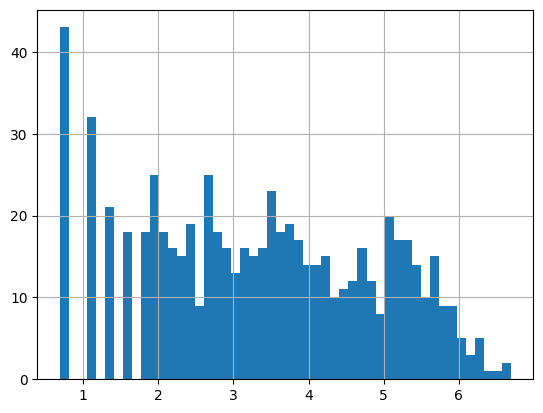

In [7]:
pd.Series([m for m in np.log(df_cross['meetings'] + 1) if m > 0]).hist(bins=50)


# PSM

In [ ]:
# Test different thresholds
results = []
for i in range(1, 100):
    # Run a PSM analysis
    df_psm = df_cross.copy()[columns_to_keep]
    # # Create treatment and control groups
    df_psm["treatment"] = (df_psm["meetings"] > i).astype(int)

    # Prepare features for PSM
    x_columns_psm = columns_to_keep[2:]

    X_psm = df_psm[x_columns_psm].copy()
    y_psm = df_psm["treatment"]

    # Fit logistic regression for propensity scores
    logit = sm.Logit(y_psm, sm.add_constant(X_psm))
    try:
        logit_fit = logit.fit()
    except Exception as e:
        print(f"Error fitting logit for threshold {i}: {e}")
        continue

    results.append({
        "threshold": i,
        # select different metrics to evaluate the model
        "aic": logit_fit.aic,
        "bic": logit_fit.bic,
        "llr": logit_fit.llr,
        "llr_pvalue": logit_fit.llr_pvalue,
        "r2_score": logit_fit.prsquared,
    })

In [9]:
pd.DataFrame(results)

,threshold,aic,bic,llr,llr_pvalue,r2_score
0,1,1047.019586,1427.355399,967.386305,8.184527e-157,0.517760
1,2,1069.558174,1449.893987,932.413215,8.889285e-150,0.502386
2,3,1086.216554,1466.552367,904.259163,3.958150e-144,0.490253
3,6,1037.128048,1417.463861,904.709231,3.215933e-144,0.503781
4,9,980.245229,1360.581041,905.624496,2.108108e-144,0.520513
5,10,964.227719,1344.563532,909.671661,3.255958e-145,0.526461
6,14,885.277690,1265.613503,922.272225,9.663079e-148,0.555067
7,21,1031.480436,1411.816249,690.205634,9.638328e-102,0.438035
8,23,804.928812,1185.264625,883.800667,4.931596e-140,0.572881
9,25,779.443218,1159.779031,883.271943,6.291070e-140,0.582358


In [10]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results['threshold'], results['r2_score'], marker='o')
plt.xlabel('Threshold')
plt.ylabel('R2 Score')
plt.title('R2 Score vs Threshold')
plt.show()

TypeError: list indices must be integers or slices, not str

<Figure size 1000x600 with 0 Axes>

## PSM

In [11]:
# Calculate propensity scores
df_psm["propensity_score"] = logit_fit.predict()

# Separate treatment and control
treatment = df_psm[df_psm["treatment"] == 1]
control = df_psm[df_psm["treatment"] == 0]

# Find nearest neighbors
nbrs = NearestNeighbors(n_neighbors=1).fit(control[["propensity_score"]])
distances, indices = nbrs.kneighbors(treatment[["propensity_score"]])

# Get matched control group
matched_control = control.iloc[indices.flatten()]

# Combine matched samples
matched_df_psm = pd.concat([treatment, matched_control])


# Check balance of covariates
def check_balance(df_psm, features, treatment_col="treatment"):
    balance_stats = []
    for feature in features:
        treated_mean = df_psm[df_psm[treatment_col] == 1][feature].mean()
        control_mean = df_psm[df_psm[treatment_col] == 0][feature].mean()
        std_diff = (treated_mean - control_mean) / np.sqrt(
            (
                df_psm[df_psm[treatment_col] == 1][feature].var()
                + df_psm[df_psm[treatment_col] == 0][feature].var()
            )
            / 2
        )
        balance_stats.append(
            {
                "Feature": feature,
                "Treated Mean": treated_mean,
                "Control Mean": control_mean,
                "Std Diff": std_diff,
            }
        )
    return pd.DataFrame(balance_stats)


# Print balance statistics
print("\nCovariate Balance After Matching:")
check_balance(matched_df_psm, x_columns_psm)


Covariate Balance After Matching:


C:\Users\caca_\AppData\Local\Temp\ipykernel_17612\3446567537.py:25: RuntimeWarning: invalid value encountered in scalar divide
  std_diff = (treated_mean - control_mean) / np.sqrt(


,Feature,Treated Mean,Control Mean,Std Diff
0,questions_log,4.179810,4.395493,-0.213795
1,country_0,0.982036,0.988024,-0.049178
2,country_AUT,0.041916,0.000000,0.294917
3,country_BEL,0.047904,0.203593,-0.481609
4,country_BGR,0.000000,0.000000,NaN
...,...,...,...,...
68,COMMITTEE_PARLIAMENTARY_TEMPORARY,0.544910,0.491018,0.107687
69,DELEGATION_JOINT_COMMITTEE,0.431138,0.389222,0.085040
70,DELEGATION_PARLIAMENTARY,1.000000,1.000000,NaN
71,DELEGATION_PARLIAMENTARY_ASSEMBLY,0.682635,0.640719,0.088413


# DID

In [12]:
# df_did = df[df["mep_id"].isin(matched_df_psm.index)]
df_did = df_monthly[df_monthly["mep_id"].isin(matched_df_psm.index)].sort_values(by=['mep_id', 'date'])

df_panel = df_did.set_index(["mep_id", "date"])

x_columns_did = ['treatment', 'received_treatment_and_started' ] + columns_to_keep[3:]


## DID regression

In [14]:
# Now, run a regression with fixed effects
from linearmodels import PanelOLS

In [15]:
# Prepare dependent and independent variables
Y = df_panel["quetions_log"]
X = df_panel[x_columns_did]

# X = X.drop(to_drop_colinear_columns, axis=1)

model = sm.OLS(Y, sm.add_constant(X))

results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           quetions_log   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     8.113
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           3.12e-18
Time:                        18:09:05   Log-Likelihood:                -169.33
No. Observations:                 520   AIC:                             374.7
Df Residuals:                     502   BIC:                             451.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

# Fixed Effects

In [16]:
# Run panel regression with entity (MEP) fixed effects
model = PanelOLS(Y, X, entity_effects=True)
results_fe = model.fit()

print(results_fe)

ValueError: The index on the time dimension must be either numeric or date-like

# Lagged effects

In [17]:
df_lagged = df_panel.copy()

df_lagged['treatment_lag1'] = df_lagged.groupby('mep_id')['treatment'].shift(1)  # 1-week lag
df_lagged['treatment_lag2'] = df_lagged.groupby('mep_id')['treatment'].shift(2)  # 2-week lag
df_lagged['treatment_lag3'] = df_lagged.groupby('mep_id')['treatment'].shift(3)  # 3-week lag

# Drop rows with NaN values created by the lag operations
df_lagged = df_lagged.dropna(subset=['treatment_lag1', 'treatment_lag2', 'treatment_lag3'])

X = df_lagged[['treatment_lag1', 'treatment_lag2', 'treatment_lag3', *x_columns_did]]
Y = df_lagged['quetions_log']

model = sm.OLS(Y, sm.add_constant(X))

results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           quetions_log   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     10.17
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           4.07e-19
Time:                        18:09:15   Log-Likelihood:                -168.86
No. Observations:                 508   AIC:                             365.7
Df Residuals:                     494   BIC:                             424.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 